Our dataset is the covtype dataset.

This is the link to download the daset: https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/

Overall description:
- m X n = 581,012 X 55
Key features including: Elevation, Aspect, Slope etc.
The last column is the cover_type classification from 1 to 7.


#1. Import the input_path fot the dataset as csv file and necessary library

In [1]:
import os
import time
#Please fill in the input folder path and the output folder path
input_path = '/Users/phupham/Desktop/UniSyd/Semester3/MachineLearning/Assignment2/covtype.csv'
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
import itertools
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import linregress

/Users/phupham/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv(input_path,header = None )
df.shape
attr_value = df.iloc[:,0:53].values
cat = df[54].values

(581012, 55)

#2. Read the value into attr_value for X and cat for Y and preliminary visualization of the data


In [4]:
'''
# Assign column name for better understanding of the dataset
df.columns = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4','Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37','Soil_Type38','Soil_Type39','Soil_Type40','Cover_Type']
df.head(5)
'''

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [14]:
'''
# Examine potential correlation between the attributes
e = df['Elevation'].values
aspect = df['Aspect'].values
h_3 = df['Hillshade_3pm'].values
h_9 = df['Hillshade_9am'].values
print(linregress(aspect, h_3))
print(linregress(h_3,h_9))
print(linregress(e,aspect))
'''

LinregressResult(slope=0.22125504394966963, intercept=108.08840898577652, rvalue=0.64694395349569167, pvalue=0.0, stderr=0.00034213377963585219)
LinregressResult(slope=-0.54575291446370666, intercept=289.93126341078766, rvalue=-0.78029595228079562, pvalue=0.0, stderr=0.0005738653954980434)
LinregressResult(slope=0.0062894696689008468, intercept=137.04396913557605, rvalue=0.015734938290299545, pvalue=3.7952628220215271e-33, stderr=0.00052432843372350938)


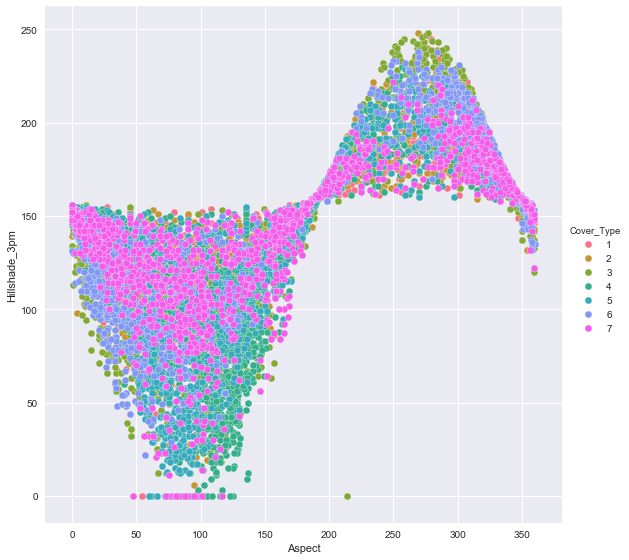

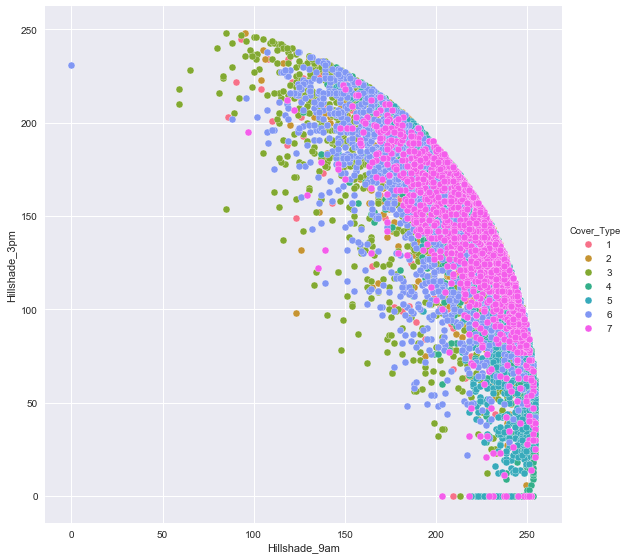

In [5]:
'''
#Visualization of the relationship between a few items 
sample_value = df.iloc[0:10000,:]
sample_value_plot = sample_value[["Aspect","Hillshade_3pm","Cover_Type","Hillshade_9am"]]
#print(attr_value_plot)
import seaborn as sns
# Between Aspect and Hillshade_3pm
sns.pairplot(sample_value_plot,size =8,hue="Cover_Type",x_vars="Aspect",y_vars="Hillshade_3pm" )

# Between Hillshade_9pm and Hillshade_3pm
sns.pairplot(sample_value_plot,size =8,hue="Cover_Type",x_vars="Hillshade_9am",y_vars="Hillshade_3pm" )
plt.show()
'''

#3. Split the data 80% for training and 20% for testing and Testing what Preprocessing is more effective

In [5]:
Trainset,Testset,Trainset_cat, Testset_cat = train_test_split(attr_value, cat,test_size=0.2, random_state=0)

#3A. Preprocessing with PCA. Below is the testing for processing part, please only run if necessary.

In [6]:
# Small data set for preprocessing test
X_train, X_test, y_train, y_test = train_test_split(Trainset, Trainset_cat, test_size=0.5, random_state=0)

In [9]:
'''
#Apply PCA to decrease the dimension of the dataset
pca = PCA(n_components=10)
newtraining = pca.fit_transform(X_train)
newtest = pca.transform(X_test)
start_time = time.time()
clf = RandomForestClassifier(max_features = "log2", n_estimators=10)
clf.fit(newtraining,y_train)
print("Processing time is %s seconds" % (time.time() - start_time))
pred = clf.predict(newtest)
a = accuracy_score(y_test, pred)
print("Accuracy is %0.5f "%a)
'''

Processing time is 14.255774974822998 seconds
Accuracy is 0.89629 


#3B. Preprocessing with Variance Feature Selection

In [13]:
'''
#Apply Variance Feature Selection
selector = VarianceThreshold(threshold = 0.1)
newtraining = selector.fit_transform(X_train)
newtest = selector.fit_transform(X_test)
start_time = time.time()
clf = RandomForestClassifier(max_features = "log2", n_estimators=10)
clf.fit(newtraining,y_train)
print("Processing time is %s seconds" % (time.time() - start_time))
pred = clf.predict(newtest)
a = accuracy_score(y_test, pred)
print("Accuracy is %0.5f "%a)
'''

Processing time is 7.327443838119507 seconds
Accuracy is 0.91735 


In [15]:
'''
selector.get_support(indices=False)
'''

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

GIVEN THE OUTCOME THAT VARIANCE FEATURE SELECTION PROVIDES A BETTER ACCURACY AS WELL AS FASTER PROCESSING TIME, WE DECIDED TO CHOOSE IT AS OUR MAIN PROCESSING METHOD

#4. 10fold-Cross-validation and apply RandomForest

In [12]:
#StratifiedKFOLD

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(Trainset,Trainset_cat)

# VARIANCE FEATURE SELECTION
selector = VarianceThreshold(threshold = 0.1)
newtraining = selector.fit_transform(Trainset)

# RANDOM FOREST MODEL
clf = RandomForestClassifier(n_estimators=30, max_features='log2')
newtest = selector.fit_transform(Testset)
n=0
acc=[]
process=[]

for train_index,test_index in skf.split(newtraining,Trainset_cat):
    X_train, X_test = newtraining[train_index], newtraining[test_index]
    y_train, y_test = Trainset_cat[train_index], Trainset_cat[test_index]
    start_time = time.time()
    clf.fit(X_train,y_train)
    t = time.time() - start_time
    print("Processing time is %s seconds" % t)
    pred = clf.predict(X_test)
    a = accuracy_score(y_test, pred)
    print("Accuracy for %d fold is %0.5f "%(n, a))
    n= n+1
    acc.append(a)
    process.append(t)
    

Processing time is 58.85648989677429 seconds
Accuracy for 0 fold is 0.94966 
Processing time is 63.79489827156067 seconds
Accuracy for 1 fold is 0.94845 
Processing time is 62.92464303970337 seconds
Accuracy for 2 fold is 0.94686 
Processing time is 60.52574396133423 seconds
Accuracy for 3 fold is 0.94839 
Processing time is 63.234123945236206 seconds
Accuracy for 4 fold is 0.94768 
Processing time is 57.48442602157593 seconds
Accuracy for 5 fold is 0.94856 
Processing time is 58.46829700469971 seconds
Accuracy for 6 fold is 0.95060 
Processing time is 57.481489181518555 seconds
Accuracy for 7 fold is 0.94854 
Processing time is 67.09354186058044 seconds
Accuracy for 8 fold is 0.94909 
Processing time is 64.50022983551025 seconds
Accuracy for 9 fold is 0.94952 


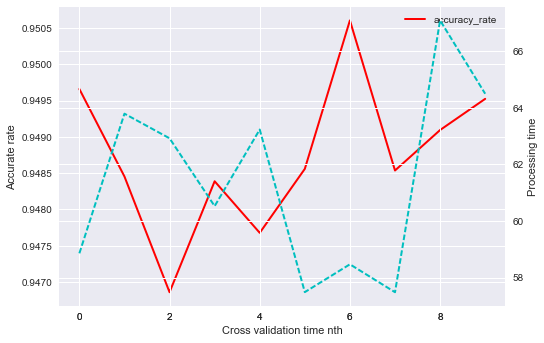

In [13]:
'''
fig1 =plt.figure()
ax1 = fig1.add_subplot(111)

line1 = ax1.plot(acc, 'r',label = "accuracy_rate",linewidth = 2,  )
ax1.set_ylabel("Accurate rate")

ax2 =fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(process, 'c--', label = "processing_time", linewidth = 2, linestyle = '--' )
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Processing time")
ax1.set_xlabel("Cross validation time nth")
#legend((line1, line2), ("accuracy_rate", "processing_time"))
#show()

ax1.legend(loc=0)
'''

#5. Apply the model to the Testset

In [22]:
start_time = time.time()
clf.fit(newtraining, Trainset_cat)
pred = clf.predict(newtest)
t = time.time() - start_time
print("Processing time is %s seconds" % t)
a = accuracy_score(Testset_cat, pred)
print(a)


Processing time is 68.67936420440674 seconds
0.952023613848


In [17]:
report = metrics.classification_report(Testset_cat,pred)
print(report)

             precision    recall  f1-score   support

          1       0.96      0.95      0.95     42212
          2       0.95      0.97      0.96     56849
          3       0.93      0.95      0.94      7094
          4       0.88      0.80      0.84       569
          5       0.94      0.75      0.83      1886
          6       0.92      0.89      0.91      3502
          7       0.98      0.95      0.96      4091

avg / total       0.95      0.95      0.95    116203



In [18]:
'''
#Table of the confusion matrix
y_true = pd.Series(Testset_cat)
y_pred = pd.Series(pred)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
'''

Predicted,1,2,3,4,5,6,7,All
True,,,,,,,,
1,40046,2080,1,0,10,7,68,42212
2,1518,55070,108,0,77,68,8,56849
3,0,156,6737,38,3,160,0,7094
4,0,0,97,453,0,19,0,569
5,28,424,15,0,1416,3,0,1886
6,1,112,255,25,1,3108,0,3502
7,192,30,0,0,0,0,3869,4091
All,41785,57872,7213,516,1507,3365,3945,116203


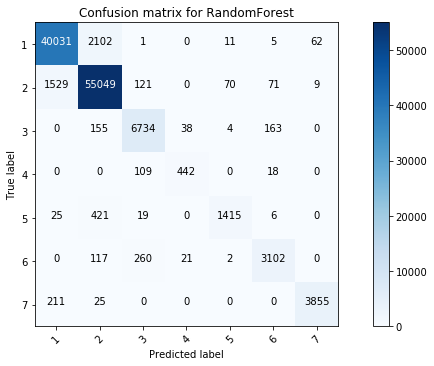

In [25]:
'''
#VISUALIZATION OF THE CONFUSTION METRICS 
#This method is taken from the sckitlearn library 
#Link: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


confusion = metrics.confusion_matrix(Testset_cat,pred)
target_name = ['1','2','3','4','5','6','7']
def plot_cmatrix(cm,classes,title= 'Confusion matrix for Covtype',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 5))
plot_cmatrix(confusion, classes=target_name,title='Confusion matrix for RandomForest')
plt.show()
'''

#Visualization of ROC Curve

In [26]:
'''
#This may take around 5-7 minutes to run
classifier = OneVsRestClassifier(clf)
predicted_prob = classifier.fit(newtraining, Trainset_cat).predict_proba(newtest)
'''

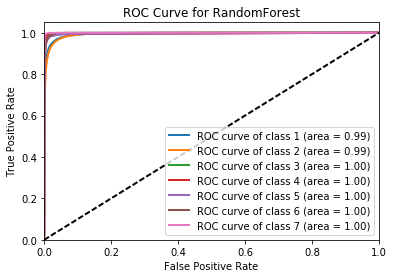

In [31]:
'''
accurate_y = label_binarize(Testset_cat, classes=[1,2,3,4,5,6,7])
n_classes = accurate_y.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range (n_classes):
    fpr[i], tpr[i], _ = roc_curve(accurate_y[:,i], predicted_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

lw =2 


for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest')
plt.legend(loc="lower right")
plt.show()
'''